In [3]:
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt
import os

### **1. Lọc dữ liệu lấy 1 sản phẩm là mã 0979, gom sản phẩm về theo ngày, sắp xếp ngày từ 2012 đến 2017**

In [4]:
df = pd.read_excel("/Users/thuytrangneee/Downloads/datasetprj.xlsx") 
df_filtered = df[df['Product_Code'] == "Product_0979"]
daily_demand = df_filtered.groupby('Date').agg(
    Total_Order_Demand=('Order_Demand', 'sum'),
    Order_Count=('Product_Code', 'count')
).reset_index()
df_sorted = daily_demand.sort_values(by='Date', ascending=True)
df_sorted.to_excel("data0979.xlsx", index=False)

### **2. Lọc sạch dữ liệu** 
- Kiểm tra null, trùng lặp và loại bỏ
- Kiểm tra cột order demand (>= 0)

In [7]:
df = pd.read_excel("/Users/thuytrangneee/Downloads/data0979.xlsx")
print(df.isnull().sum())
duplicate_dates = df['Date'].duplicated().sum()
if duplicate_dates > 0:
    df_cleaned = df.drop_duplicates(subset=['Date'], keep='first').reset_index(drop=True)
else:
    df_cleaned = df.copy()
df_cleaned_demand = df[df['Total_Order_Demand'] >= 0].copy()
df_cleaned = df_cleaned_demand.copy()
df_cleaned.loc[df_cleaned['Total_Order_Demand'] == 0, 'Order_Count'] = 0
df_cleaned.to_excel("/Users/thuytrangneee/Downloads/data0979_cleaned.xlsx", index=False)
df_cleaned.describe()

Date                  0
Total_Order_Demand    0
Order_Count           0
dtype: int64


,Date,Total_Order_Demand,Order_Count
count,1019,1019.000000,1019.000000
mean,2014-06-25 10:50:02.944062720,2971.736997,2.224730
min,2012-01-05 00:00:00,0.000000,0.000000
25%,2013-03-30 12:00:00,400.000000,1.000000
50%,2014-07-02 00:00:00,1000.000000,2.000000
75%,2015-09-15 12:00:00,4000.000000,3.000000
max,2016-12-26 00:00:00,22500.000000,9.000000
std,NaN,4299.731113,1.273709


### **3. Vẽ biểu đồ thể hiện order demand**

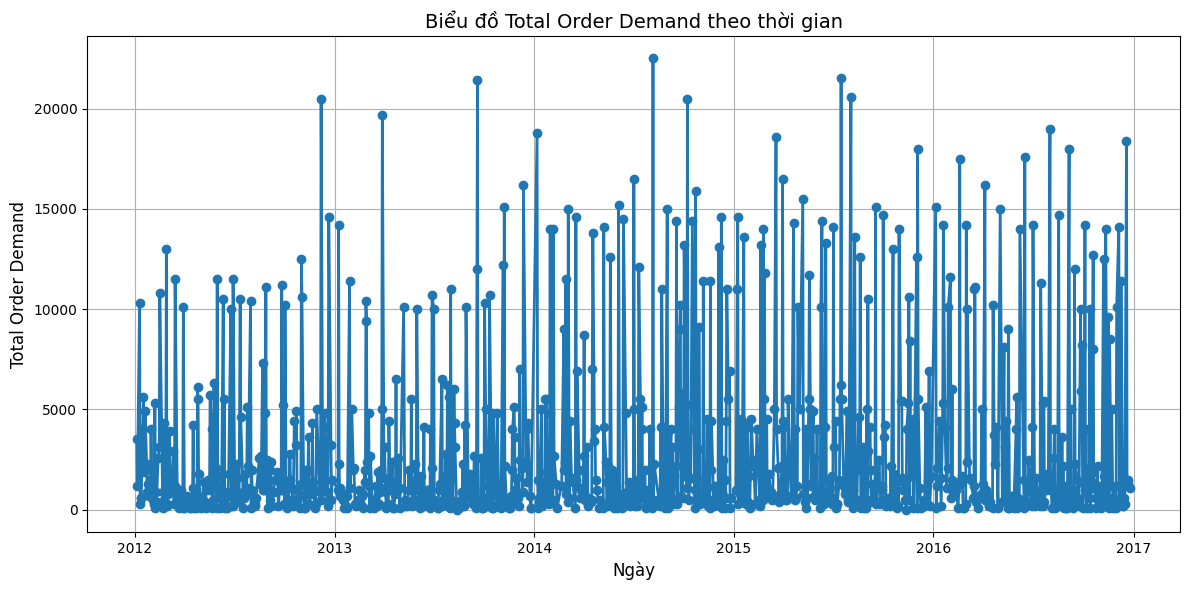

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Đọc file ---
df = pd.read_excel("/Users/thuytrangneee/Downloads/data0979_cleaned.xlsx")

# --- Chuyển cột Date về kiểu datetime ---
df['Date'] = pd.to_datetime(df['Date'])

# --- Vẽ biểu đồ Total Order Demand theo thời gian ---
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Total_Order_Demand'], marker='o', linestyle='-', linewidth=2)

# --- Tùy chỉnh hiển thị ---
plt.title("Biểu đồ Total Order Demand theo thời gian", fontsize=14)
plt.xlabel("Ngày", fontsize=12)
plt.ylabel("Total Order Demand", fontsize=12)
plt.grid(True)
plt.tight_layout()

# --- Hiển thị biểu đồ ---
plt.show()

#### **Nhận xét**
- Dataset có độ dao động mạnh, chứng tỏ nhu cầu biến động thất thường, có thể chịu ảnh hưởng bởi mùa vụ, khuyến mãi hoặc yếu tố bên ngoài.
- Các đoạn nhọn, gấp khúc lớn cho thấy sự biến động cao (biên độ dao động lớn giữa các ngày)
- Do trên dataset chưa có nhiều thông tin, nên ta phải thêm thông tin vào để có thể phân tích dự đoán sâu hơn

### **4. Thêm đặc tính cho dataset**
- Với các ngày không xuất hiện trong dataset trong khoảng năm từ 2012 đến hết 2016, ta để order demand = 0 để dataset có tính liên tục
- Thêm tính mùa vụ như mùa, ngày lễ (theo lịch quốc tế), các ngày kích cầu mua sắm như Black Friday vào
- Như đã nói ở trên, do dataset chưa có nhiều thông tin, nên ta giả định rằng các đỉnh nhọn cao bất thường liên quan đến khuyến mãi, ta thêm biến nhị phân biểu diễn "khuyến mãi" vào dataset - gán 1 cho các giá trị vượt 2 độ lệch chuẩn so với trung bình

In [10]:
import pandas as pd
import numpy as np

# --- Đọc dữ liệu ---
df = pd.read_excel("/Users/thuytrangneee/Downloads/data0979_cleaned.xlsx")

# --- Chuẩn hóa cột Date ---
df['Date'] = pd.to_datetime(df['Date'])

# --- Tạo dải ngày đầy đủ từ 2012 đến 2016 ---
full_range = pd.date_range(start="2012-01-01", end="2016-12-31")

# --- Reindex để thêm các ngày còn thiếu, gán demand = 0 ---
df = df.set_index('Date').reindex(full_range).rename_axis('Date').reset_index()
df['Total_Order_Demand'] = df['Total_Order_Demand'].fillna(0)
df['Order_Count'] = df['Order_Count'].fillna(0)

# --- Thêm biến mùa ---
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

df['Season'] = df['Date'].dt.month.apply(get_season)

# --- Thêm biến ngày lễ (quốc tế) ---
def is_international_holiday(date):
    if ((date.month == 1 and date.day == 1) or         # New Year
        (date.month == 12 and date.day == 25)):        # Christmas
        return 1
    return 0

df['Holiday'] = df['Date'].apply(is_international_holiday)

# --- Thêm biến Black Friday (ngày thứ 6 sau lễ Tạ ơn tháng 11) ---
def get_black_friday(year):
    # Lễ Tạ ơn: thứ Năm lần thứ 4 của tháng 11
    november = pd.date_range(f"{year}-11-01", f"{year}-11-30", freq='D')
    thursdays = november[november.weekday == 3]
    thanksgiving = thursdays[3]
    black_friday = thanksgiving + pd.Timedelta(days=1)
    return black_friday

black_fridays = [get_black_friday(y) for y in range(2012, 2017)]
df['Black_Friday'] = df['Date'].isin(black_fridays).astype(int)

# --- Thêm biến Promotion (giả định các đỉnh nhọn là khuyến mãi) ---
threshold = df['Total_Order_Demand'].mean() + 2 * df['Total_Order_Demand'].std()
df['Promotion'] = np.where(df['Total_Order_Demand'] >= threshold, 1, 0)

# --- Xuất file hoàn chỉnh ---
df.to_excel("/Users/thuytrangneee/Downloads/data0979_enriched.xlsx", index=False)
